In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import graphviz
from graphviz import Digraph
from utils.utils import topological_sort
#https://stackoverflow.com/questions/52472611/how-do-i-make-sure-the-graphviz-executables-are-on-my-systems-path
os.environ["PATH"] += os.pathsep + r'C:/Program Files/Graphviz/bin/'
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [5]:
h = 0.001
x = -3.0
(f(x + h) - f(x))/h

-21.996999999998934

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope -3.000000000010772


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope 2.0000000000042206


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope 0.9999999999976694


Building the Value Object

In [10]:
class Value:
    def __init__(self,data):
        self.data = data
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data)
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a + b
a * b
a*b + c

Value(data=4.0)

The above implementation cannot maintain a computation graph. Hence its required that each node/value keep track of which values hold data and connected to it

In [11]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = ()):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        self._prev = set(_children)
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other))
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other))
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a + b
a * b
#a*b results in a Value object with _prev
#The object from a*b is fed into the addition method
#and the final object will also have a _prev
d = a*b + c
d

Value(data=4.0)

In [12]:
d._prev

{Value(data=-6.0), Value(data=10)}

Currently we still dont know which operation created the d value

In [13]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out

The above expressions are simple. But they get large very fast. Hence we need a way to visualize these functions. 

In [14]:
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for i in v._prev:
            edges.add((v,i,v._op))
            build(i)
    build(root)
    return nodes,edges

def obtain_label(edge):
    key_names = {'child_name':None,
                 'parent_name':None,
                 'operation':None}
    child = edge[1]
    parent = edge[0]
    op = edge[2]
    if child.label == '':
        key_names['child_name'] = f"{child._op} \n Value = {child.data}"
    else:
        key_names['child_name'] = child.label
    if parent.label == '':
        key_names['parent_name'] = f"{parent._op} \n Value = {parent.data}"
    else:
        key_names['parent_name'] = parent.label
    key_names['operation'] = op
    return key_names




def build_graph(root):
    nodes,edges = trace(root)
    dot = graphviz.Digraph('computation_graph',graph_attr={'rankdir' : 'LR'})
    # id_node_dict = {}
    for node in nodes:
        uid = str(id(node))
        dot.node(uid,label = f"{node.label} | Value = {np.round(node.data,4)} | Grad = {np.round(node.grad,4)}",shape = 'record')
        #if node._op is not empty that means the node is a result of an operation. So we connect the operation to the resultant node 
        if node._op != '':
            dot.node(uid + f"_{node._op}",label = f"{node._op}")
            dot.edge(uid + f"_{node._op}",uid)
        # else:
        #     #this means its a result of an operation
        #     uid = str(id(node))
        #     dot.node(uid,label = f"{node.label} | \n Value = {node.data}",shape = 'record')
    for edge in edges:
        # required_data = obtain_label(edge)
        # dot.edge(required_data['child_name'],required_data['parent_name'])
        dot.edge(str(id(edge[1])),str(id(edge[0])) + f"_{edge[2]}")
    return dot

Create a Variable inside the value class that maintains the derivative of the loss function with respect to that value

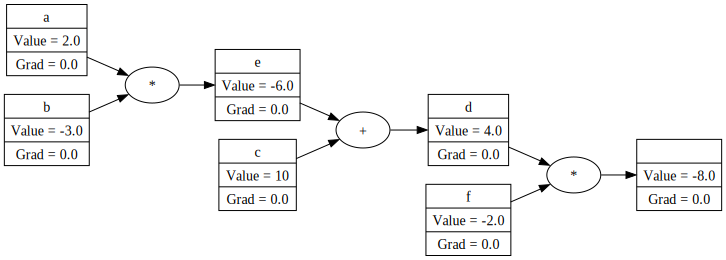

In [15]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out
    
a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10,label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0,label = 'f')
L = d * f
L
build_graph(L)

L = d*f

dL/dd = f


In [16]:
L.grad = 1
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad*b.data
b.grad = e.grad*a.data

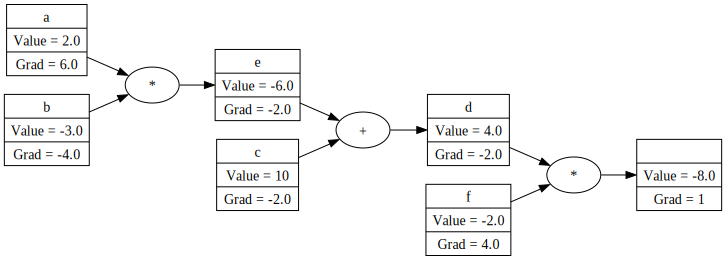

In [17]:
build_graph(L)

If we change **c** a bit how does it impact **L through d**

dd / dc = 1

dL/dc = dL/dd * dd/dc

The local node, a + node or * node has no understanding or knowledge of the other nodes. It has only knowledge of taking in 2 inputs and producing 1 output by doing a simple operation on it.

Hence it can know the local influence of the input on the output (i.e. the derivative)

"+" node:

As the derivative of a "+" node is only 1, a "+" node is only routing the derivative from upstream. **The "+" node simply distributes the derivative to all the leaf nodes**

It is always upstream gradient * local gradient

<h3> Backprop through a neuron </h3>

In [18]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out
    #we dont need to have the most atomic pieces of a function
    #we can have arbitary points of abstraction
    #only thing that matters is how to differentiate
    #create the local derivative
    def tanh(self):
        num = np.exp(self.data * 2) - 1
        den = np.exp(self.data * 2) + 1
        out = Value(num/den,_children = (self,),_op='tanh')
        return out

In [19]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'
o

Value(data=0.7071067811865476)

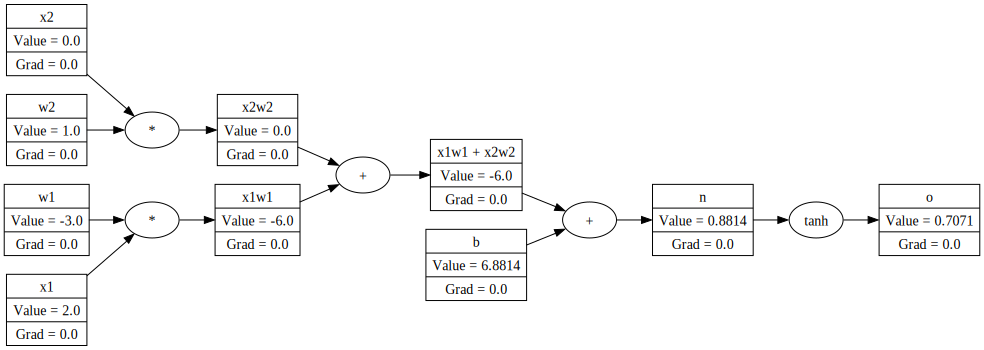

In [20]:
build_graph(o)

In [21]:
o.grad = 1
n.grad = 1 - (o.data**2)
b.grad = n.grad
x1w1x2w2.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad
w2.grad = x2w2.grad*x2.data
x2.grad = x2w2.grad*w2.data
w1.grad = x1w1.grad*x1.data
x1.grad = x1w1.grad*w1.data

Note that the gradient, says that if the output were to increase by a small nudge in the value, the output changes + or - depending on the sign of the gradient.

Also note that x2 is zero and w2 grad is 0. This means that if we nudge w2, it wont cause an effect on x2w2 because x2 is zero.

In order to increase the value of **o**, we should increase the value of w1, decrease the value of x1

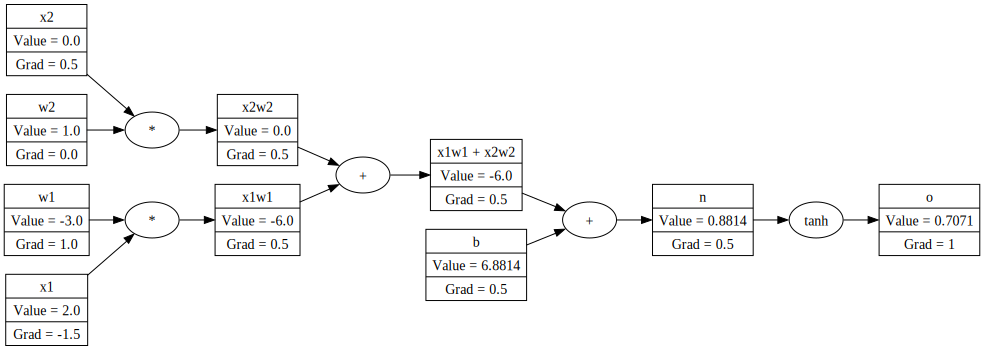

In [22]:
build_graph(o)

<h3>Doing backwards pass automatically </h3>

For addition we need to take the out.grad value and propagate it to self and other

In [23]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        #a function which will do the chain rule at each node. 
        #how to chain upstream grad to local grad
        #for default, it doesnt do anything(e.g leaf node)
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        #here we are adding, meaning that a gradient is involved and an operation should be defined here
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        #we are assigning the backprop function to the "non leaf node"
        #these functions done return anything
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    #we dont need to have the most atomic pieces of a function
    #we can have arbitary points of abstraction
    #only thing that matters is how to differentiate
    #create the local derivative
    def tanh(self):
        num = np.exp(self.data * 2) - 1
        den = np.exp(self.data * 2) + 1
        t = num/den
        out = Value(t,_children = (self,),_op='tanh')
        def _backward():
            self.grad = (1 - t**2)*out.grad
        out._backward = _backward
        return out

In [24]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'

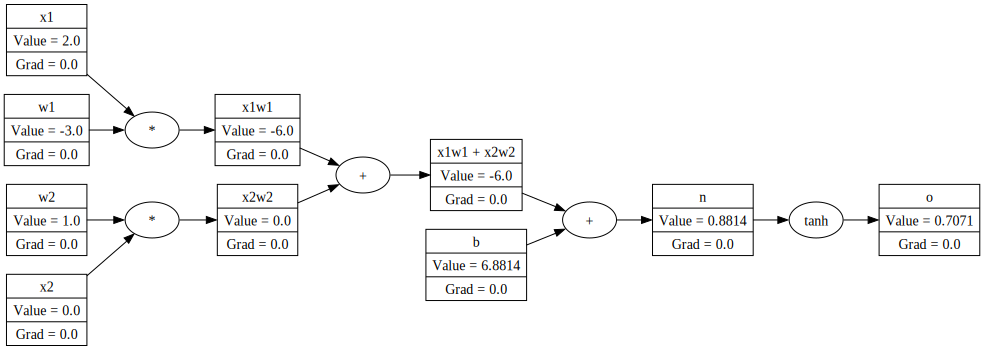

In [25]:
build_graph(o)

In [26]:
#as the starting point, we need to set o.grad to 1
o.grad = 1

In [27]:
o._backward()
n._backward()

In [28]:
b._backward()

In [29]:
x1w1x2w2._backward()

In [30]:
x1w1._backward()
x2w2._backward()

Right now we have called everything manually. But we want to do this automatically.

Before calling ._backward() on any node, we need to ensure that all the nodes after it has already called ._backward(). Everything a node depends on has to propagate into it.

This ordering of graphs can be achieved using Topological Sort

Toplogical Sort

In [31]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'

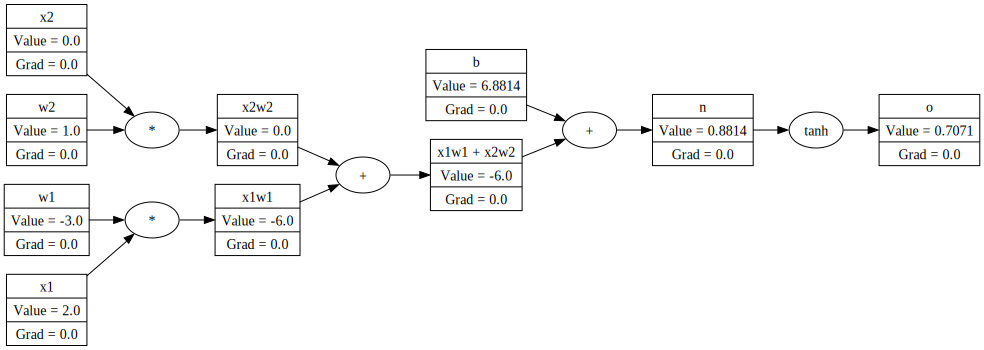

In [32]:
build_graph(o)

In [33]:
#set dL/dL = 1
o.grad = 1

topo = []
visited = set()
def build_topo(v):
    #maintain the visited nodes
    if v not in visited:
        visited.add(v)
        #go through all the children nodes
        #and add them from right to left starting from
        #root node
        for child in v._prev:
            build_topo(child)
        #Note that the first appending occurs at the leaf nodes
        #The initial root node adds itself to topo only after all the children
        #are added to it. 
        #This function guarantees that the parent is added only after the
        #children are added
        topo.append(v)
build_topo(o)

#reverse the topo from build_topo because it has the first 
#entry as the leaf nodes
for node in reversed(topo):
    node._backward()

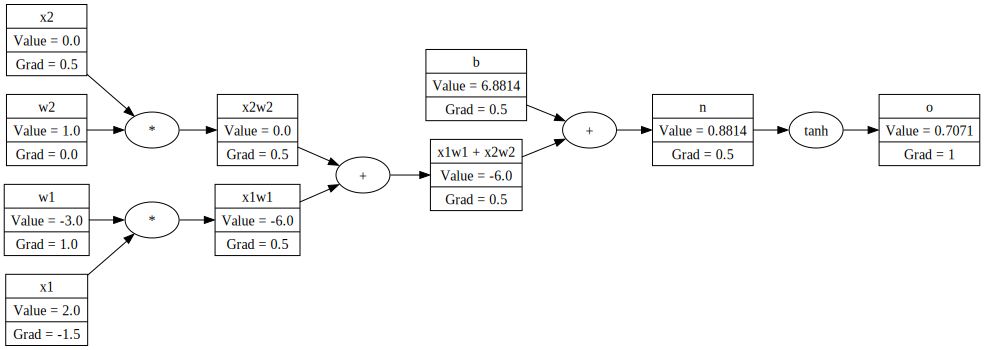

In [34]:
build_graph(o)

In [35]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'
_,_,_,top = topological_sort(o)

In [36]:
o.grad = 1
for node in reversed(top):
    node._backward()

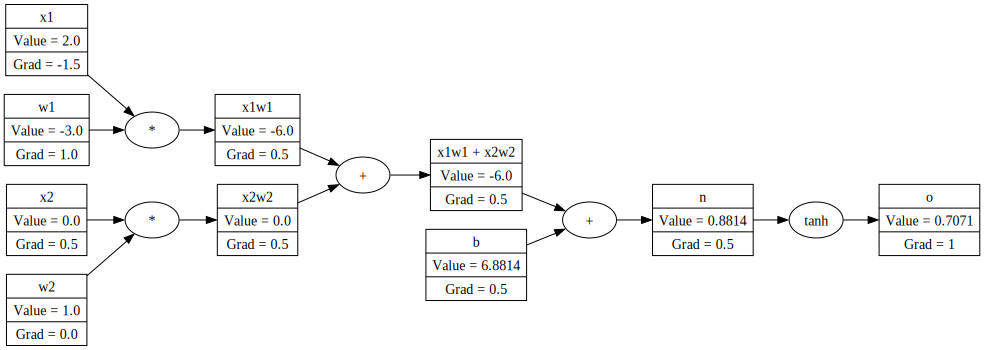

In [37]:
build_graph(o)

Value class with back prop

In [38]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        #a function which will do the chain rule at each node. 
        #how to chain upstream grad to local grad
        #for default, it doesnt do anything(e.g leaf node)
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        #here we are adding, meaning that a gradient is involved and an operation should be defined here
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        #we are assigning the backprop function to the "non leaf node"
        #these functions done return anything
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    #we dont need to have the most atomic pieces of a function
    #we can have arbitary points of abstraction
    #only thing that matters is how to differentiate
    #create the local derivative
    def tanh(self):
        num = np.exp(self.data * 2) - 1
        den = np.exp(self.data * 2) + 1
        t = num/den
        out = Value(t,_children = (self,),_op='tanh')
        def _backward():
            self.grad = (1 - t**2)*out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            #maintain the visited nodes
            #This is important if one node is connected to multiple
            #other nodes
            if v not in visited:
                visited.add(v)
                #go through all the children nodes
                #and add them from right to left starting from
                #root node
                for child in v._prev:
                    build_topo(child)
                #Note that the first appending occurs at the leaf nodes
                #The initial root node adds itself to topo only after all the children
                #are added to it. 
                #This function guarantees that the parent is added only after the
                #children are added
                topo.append(v)
        build_topo(self)
        
        #reverse the topo from build_topo because it has the first 
        #entry as the leaf nodes
        self.grad = 1
        for node in reversed(topo):
            node._backward()

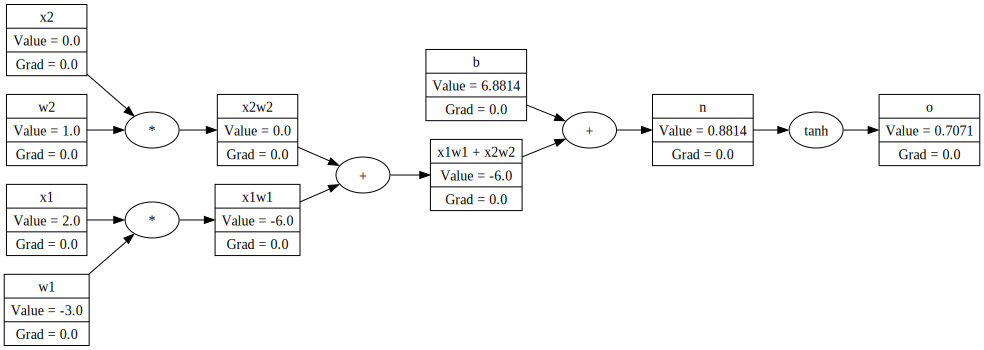

In [39]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'

build_graph(o)

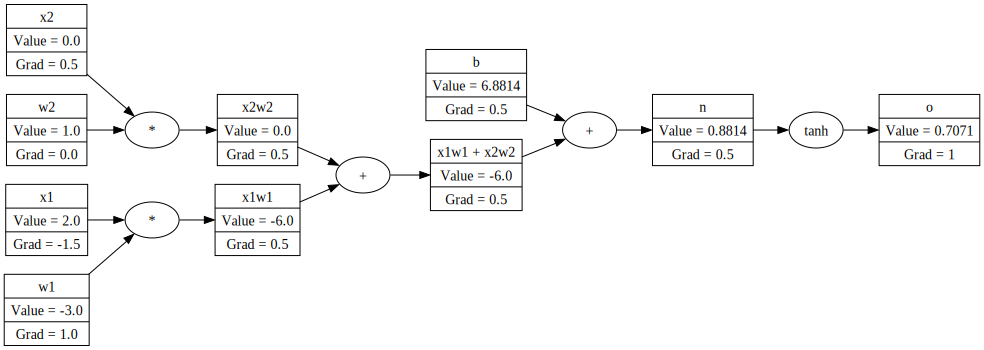

In [40]:
o.backward()
build_graph(o)

In [41]:
# a = Value(2.0,label = 'a')
# b = Value(-3.0,label = 'b')
# c = Value(10,label = 'c')
# e = a*b
# e.label = 'e'
# d = e + c
# d.label = 'd'
# f = Value(-2.0,label = 'f')
# h = a*c
# h.label = 'h'
# L = d * f
# L.label = 'L'
# m = L + h
# m.label = m

Bugs in the above approach

- Create a single node **a** and create another node which is **a + a**

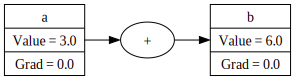

In [42]:
a = Value(3.0,label = 'a')
b = a + a
b.label = 'b'
build_graph(b)

There is 2 arrows on top of each other

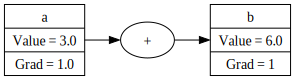

In [43]:
b.backward()
build_graph(b)

The above gradient is wrong. 

In the Value object, _backward for the addition operation is given by 

```
self.grad = ....
other.grad = ....
```

But in the above case self and other are the same node. Hence we are overwriting it.

Another example

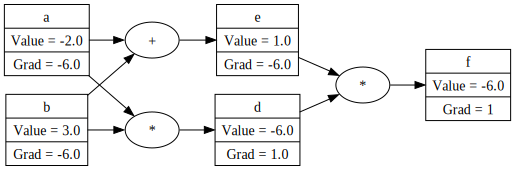

In [44]:
a = Value(-2.0,label = 'a')
b = Value(3.0,label = 'b')
d = a * b;d.label = 'd'
e = a + b;e.label = 'e'
f = d * e;f.label = 'f'
f.backward()
build_graph(f)

Fundamentally the issue occurs if we use a variable more than once.

Hence the solution is to accumulate the gradients

In [45]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        #a function which will do the chain rule at each node. 
        #how to chain upstream grad to local grad
        #for default, it doesnt do anything(e.g leaf node)
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        #here we are adding, meaning that a gradient is involved and an operation should be defined here
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        #we are assigning the backprop function to the "non leaf node"
        #these functions done return anything
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    #we dont need to have the most atomic pieces of a function
    #we can have arbitary points of abstraction
    #only thing that matters is how to differentiate
    #create the local derivative
    def tanh(self):
        num = np.exp(self.data * 2) - 1
        den = np.exp(self.data * 2) + 1
        t = num/den
        out = Value(t,_children = (self,),_op='tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            #maintain the visited nodes
            #This is important if one node is connected to multiple
            #other nodes
            if v not in visited:
                visited.add(v)
                #go through all the children nodes
                #and add them from right to left starting from
                #root node
                for child in v._prev:
                    build_topo(child)
                #Note that the first appending occurs at the leaf nodes
                #The initial root node adds itself to topo only after all the children
                #are added to it. 
                #This function guarantees that the parent is added only after the
                #children are added
                topo.append(v)
        build_topo(self)
        
        #reverse the topo from build_topo because it has the first 
        #entry as the leaf nodes
        self.grad = 1
        for node in reversed(topo):
            node._backward()

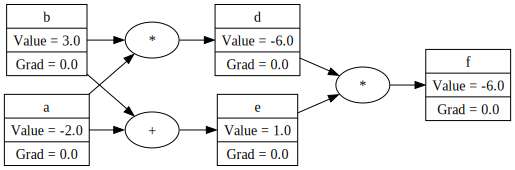

In [46]:
a = Value(-2.0,label = 'a')
b = Value(3.0,label = 'b')
d = a * b;d.label = 'd'
e = a + b;e.label = 'e'
f = d * e;f.label = 'f'
# f.backward()
build_graph(f)

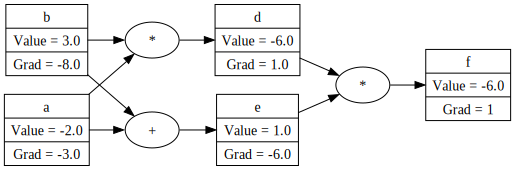

In [47]:
f.backward()
build_graph(f)

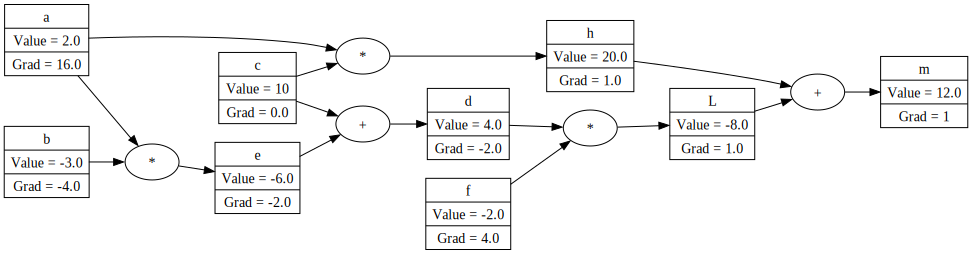

In [48]:
a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10,label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0,label = 'f')
h = a*c
h.label = 'h'
L = d * f
L.label = 'L'
m = L + h
m.label = 'm'
m.backward()
build_graph(m)

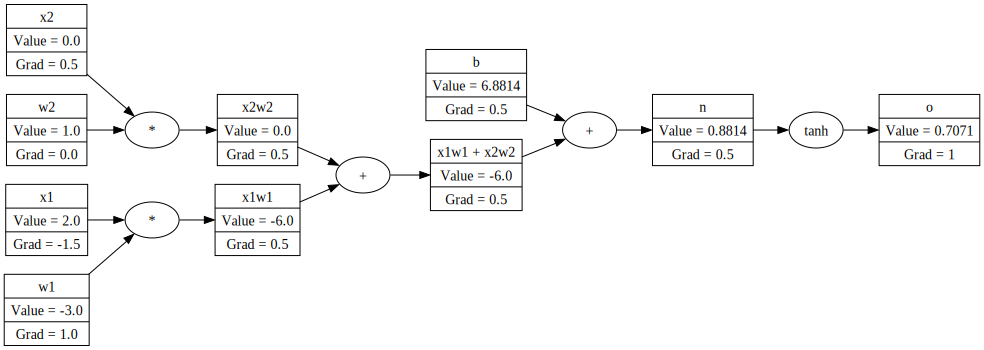

In [49]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'
o.backward()
build_graph(o)

Issues with the value object

- Currently cannot add/multiply constants to a Value object
    - To fix this we can do a check if the incoming other is a Value object. If not wrap the constant in a Value object
- However we still have the issue of only the right object being able to be a constant
    - Hence we need to implement __rmul__ which is fall back incase __mul__ doesnt work




In [119]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        #a function which will do the chain rule at each node. 
        #how to chain upstream grad to local grad
        #for default, it doesnt do anything(e.g leaf node)
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        #if other is already a Value object, leave it alone
        #else Value(other) means to wrap the values in a Value object
        other = other if isinstance(other,Value) else Value(other) 
        #here we are adding, meaning that a gradient is involved and an operation should be defined here
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        #we are assigning the backprop function to the "non leaf node"
        #these functions done return anything
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out 
    
    def __pow__(self,other):
        # other = other if isinstance(other,Value) else Value(other)
        assert isinstance(other,(int,float)),"Only accept int or float"
        out = Value(self.data ** other,_children = (self,),_op = f'**{other}')
        def _backward():
            self.grad += out.grad * (other*(self.data**(other-1)))
        out._backward = _backward
        return out
    
    def __rmul__(self,other):#other * self
        return self * other
    def __truediv__(self,other):
        #NOTE : If other is just a constant, 
        #__pow__ is not accessed
        #It is only accessed if other is a Value
        return self * (other**-1)
    
    def __radd__(self,other):
        return self + other

    def __neg__(self):
        #to implement negation, we mltiply by one. 
        #the backward pass for this will be done using the one in the
        #multiply method
        return self * -1
    def __sub__(self,other):
        #the substract method is done by addition of a negation
        #the backward pass is implmented in the __add__ method
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),_children = (self,),_op = 'exp')
        def _backward():
            self.grad += out.grad*out.data
        out._backward = _backward
        return out

    #we dont need to have the most atomic pieces of a function
    #we can have arbitary points of abstraction
    #only thing that matters is how to differentiate
    #create the local derivative
    def tanh(self):
        num = np.exp(self.data * 2) - 1
        den = np.exp(self.data * 2) + 1
        t = num/den
        out = Value(t,_children = (self,),_op='tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out
        # return c/d
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            #maintain the visited nodes
            #This is important if one node is connected to multiple
            #other nodes
            if v not in visited:
                visited.add(v)
                #go through all the children nodes
                #and add them from right to left starting from
                #root node
                for child in v._prev:
                    build_topo(child)
                #Note that the first appending occurs at the leaf nodes
                #The initial root node adds itself to topo only after all the children
                #are added to it. 
                #This function guarantees that the parent is added only after the
                #children are added
                topo.append(v)
        build_topo(self)
        
        #reverse the topo from build_topo because it has the first 
        #entry as the leaf nodes
        self.grad = 1
        for node in reversed(topo):
            node._backward()

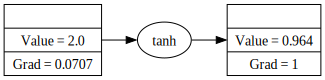

In [101]:
a = Value(2.0)
c = a.tanh()
c.backward()
build_graph(c)

In [102]:
c._prev

{Value(data=2.0)}

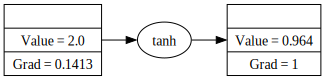

In [103]:
c.backward()
build_graph(c) 

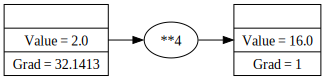

In [104]:
b = a**4
b.backward()
build_graph(b)

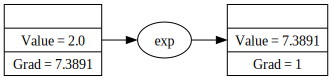

In [ ]:
a = Value(2.0)
b = a.exp()
b.backward()
build_graph(b)

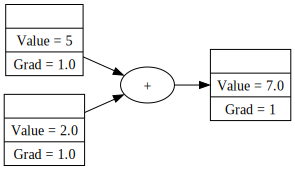

In [ ]:
b.backward()
build_graph(b)

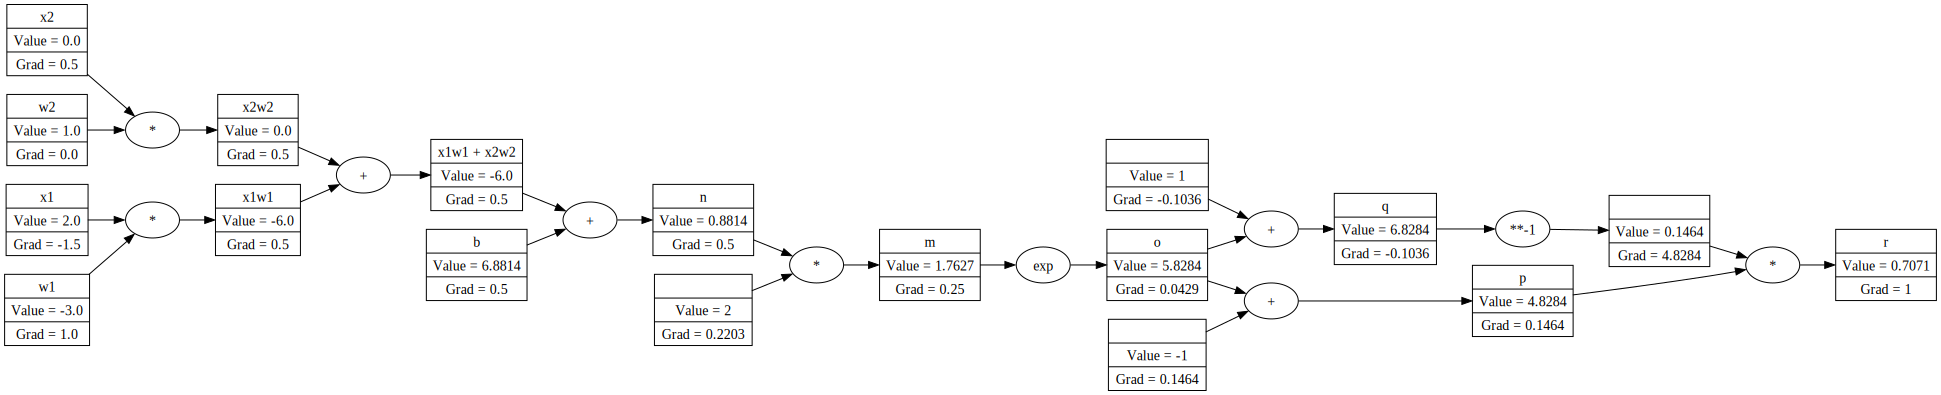

In [120]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
##implement tanh by breaking it down
m = n*2;m.label = 'm'
o = m.exp();o.label = 'o'
p = o - 1;p.label = 'p'
q = o + 1;q.label = 'q'
r = p/q;r.label = 'r'
r.backward()
build_graph(r)

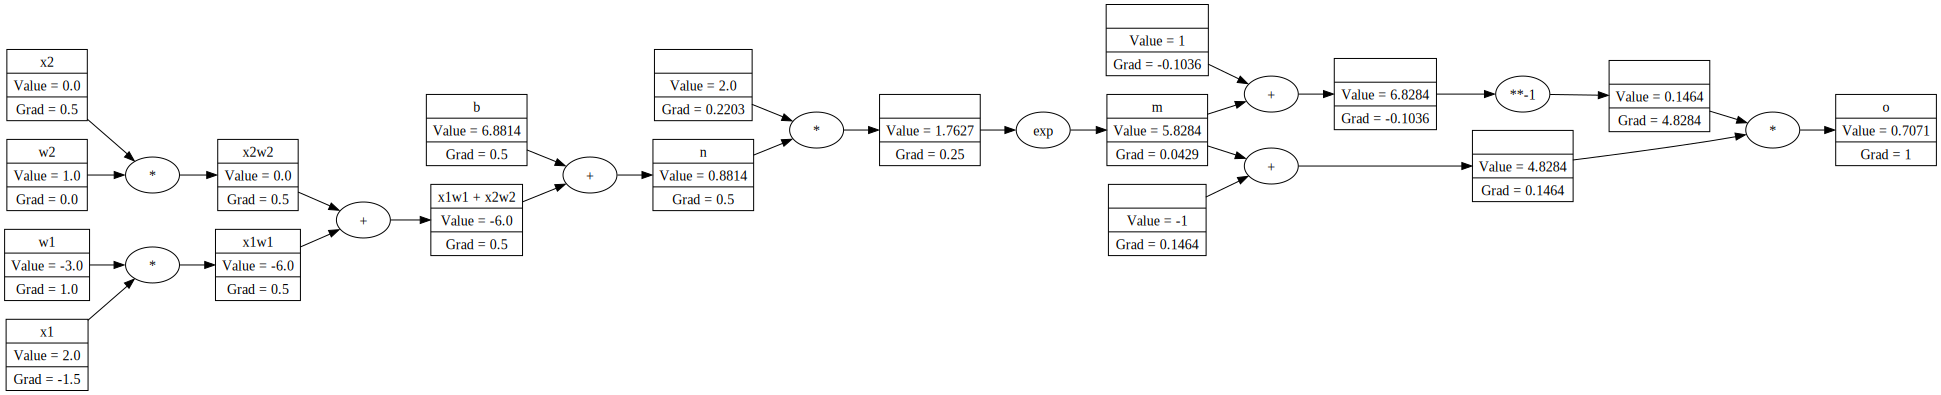

In [121]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
##implement tanh by breaking it down
m = (2.0*n).exp();m.label = 'm'
o = (m - 1)/(m+1);o.label = 'o'
o.backward()
build_graph(o)